In [ ]:
# just to help me run on kaggle, not part of the actual code for the assignment, so please ignore this part
# to be deleted before submission (but if it is still here and not deleted, it is because I forgot to delete it, so please ignore it or comment it out, thank you!)
!git clone https://github.com/beckhamtoh/DSA4262.git
%cd "DSA4262/Individual Assignment 2"

# Imports

In [2]:
import os
import re
import json
import random
from dataclasses import dataclass

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, precision_score, recall_score, classification_report,
    confusion_matrix
)

# Configurations
np.random.seed(4262)
random.seed(4262)

TRAIN_PATH = "dreaddit-train.csv"
TEST_PATH  = "dreaddit-test.csv"

TARGET_COL = "label"
TEXT_COL   = "text"
GROUP_COL  = "subreddit"
CONF_COL   = "confidence"
ID_COL     = "id"

# Load data

In [10]:
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

train_df.head(2)


Train shape: (2838, 116)
Test shape : (715, 116)


,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.125,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857


In [ ]:
# check all the columns in the train dataset
print("Columns in train dataset:", train_df.columns.tolist())


Columns in train dataset: ['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label', 'confidence', 'social_timestamp', 'social_karma', 'syntax_ari', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function', 'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they', 'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep', 'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj', 'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number', 'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger', 'lex_liwc_sad', 'lex_liwc_social', 'lex_liwc_family', 'lex_liwc_friend', 'lex_liwc_female', 'lex_liwc_male', 'lex_liwc_cogproc', 'lex_liwc_insight', 'lex_liwc_cause', 'lex_liwc_discrep', 'lex_liwc_tentat', 'lex_liwc_certain', 'le

In [ ]:
# check the distribution of the target variable
train_df[TARGET_COL] = train_df[TARGET_COL].astype(int)
test_df[TARGET_COL]  = test_df[TARGET_COL].astype(int)

print(train_df[TARGET_COL].value_counts())

label
1    1488
0    1350
Name: count, dtype: int64


# Exploratory Data Analysis

## Class balance

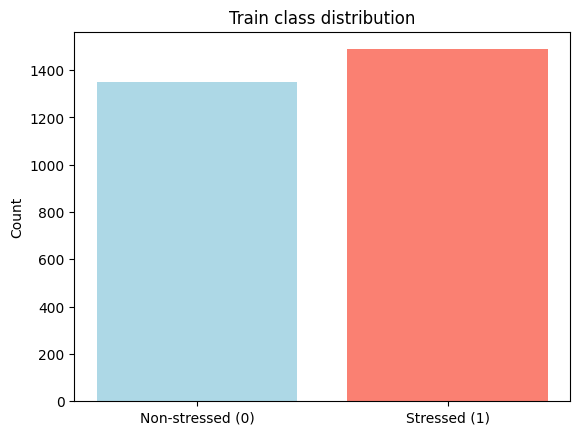

In [17]:
counts = train_df[TARGET_COL].value_counts().sort_index()
plt.figure()
plt.bar(["Non-stressed (0)", "Stressed (1)"], counts.values, color=["lightblue", "salmon"])
plt.title("Train class distribution")
plt.ylabel("Count")
plt.show()

## Post length distribution

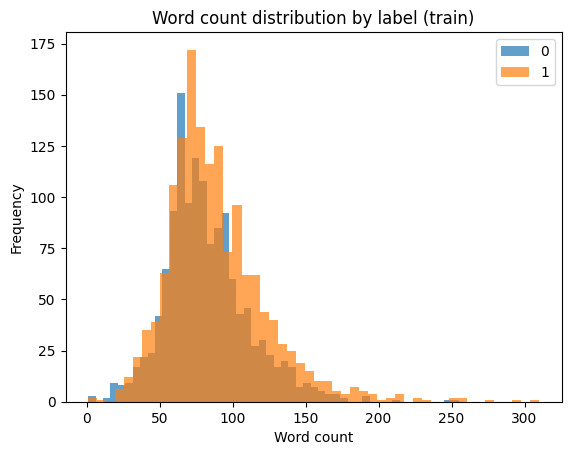

In [18]:
train_df["word_count"] = train_df[TEXT_COL].str.split().apply(len)

plt.figure()
plt.hist(train_df.loc[train_df[TARGET_COL] == 0, "word_count"], bins=50, alpha=0.7, label="0")
plt.hist(train_df.loc[train_df[TARGET_COL] == 1, "word_count"], bins=50, alpha=0.7, label="1")
plt.title("Word count distribution by label (train)")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Subreddit breakdown + stressed rate

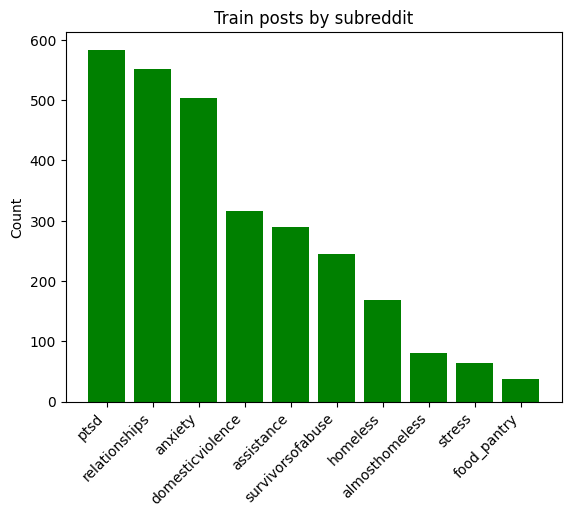

In [23]:
sub_counts = train_df[GROUP_COL].value_counts()

plt.figure()
plt.bar(sub_counts.index, sub_counts.values, color="green")
plt.title("Train posts by subreddit")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.show()

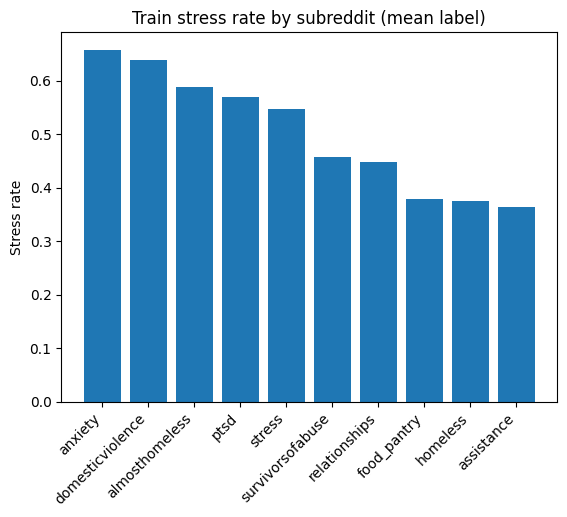

In [24]:
sub_stress_rate = train_df.groupby(GROUP_COL)[TARGET_COL].mean().sort_values(ascending=False)

plt.figure()
plt.bar(sub_stress_rate.index, sub_stress_rate.values)
plt.title("Train stress rate by subreddit (mean label)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Stress rate")
plt.show()

## Label confidence distribution

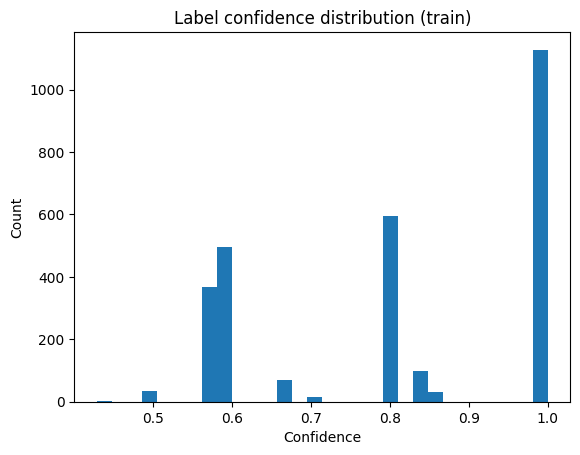

In [25]:
plt.figure()
plt.hist(train_df[CONF_COL].dropna(), bins=30)
plt.title("Label confidence distribution (train)")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.show()

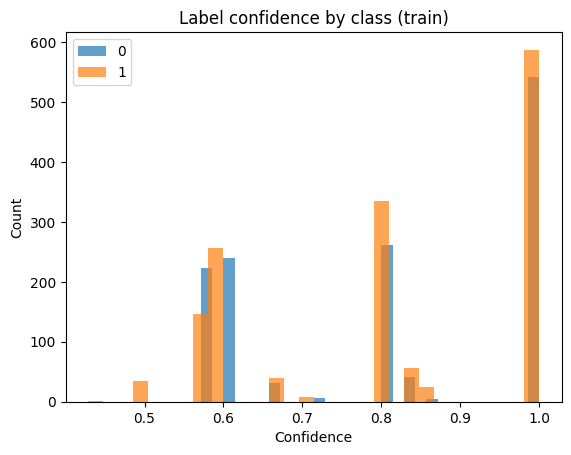

In [26]:
plt.figure()
plt.hist(train_df.loc[train_df[TARGET_COL]==0, CONF_COL].dropna(), bins=30, alpha=0.7, label="0")
plt.hist(train_df.loc[train_df[TARGET_COL]==1, CONF_COL].dropna(), bins=30, alpha=0.7, label="1")
plt.title("Label confidence by class (train)")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.legend()
plt.show()

# Stress in each subreddit

subreddit
anxiety             0.658052
domesticviolence    0.639241
almosthomeless      0.587500
ptsd                0.568493
stress              0.546875
survivorsofabuse    0.457143
relationships       0.447464
food_pantry         0.378378
homeless            0.375000
assistance          0.363322
Name: label, dtype: float64


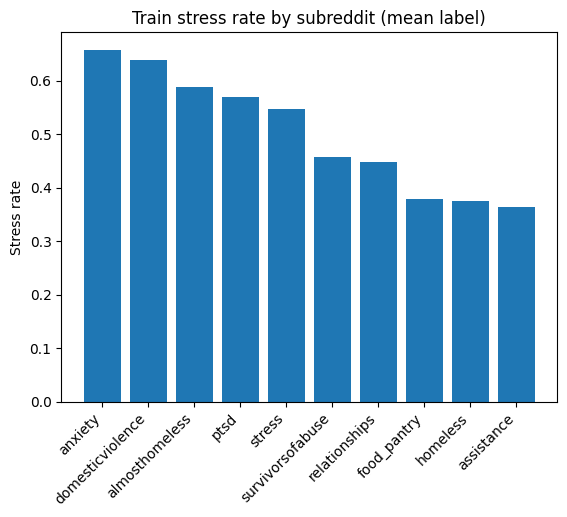

In [33]:
# check for stress rate in each subreddit
sub_stress_rate = train_df.groupby(GROUP_COL)[TARGET_COL].mean().sort_values(ascending=False)
print(sub_stress_rate)

# plot the stress rate by subreddit
plt.figure()
plt.bar(sub_stress_rate.index, sub_stress_rate.values)
plt.title("Train stress rate by subreddit (mean label)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Stress rate")
plt.show()

# Build feature lists
this is so we can automatically detect numeric feature columns so that it works even if column order is different for the train and test data

In [ ]:
# Numeric columns = all number-like columns except target
numeric_cols = []
for c in train_df.columns:
    if c in [TARGET_COL, TEXT_COL, GROUP_COL]:
        continue
    if pd.api.types.is_numeric_dtype(train_df[c]):
        numeric_cols.append(c)

# Sometimes IDs are numeric but not useful as features
for drop in [ID_COL]:
    if drop in numeric_cols:
        print(f"Dropping numeric column: {drop}")
        numeric_cols.remove(drop)

print("Num numeric feature cols:", len(numeric_cols))
numeric_cols[:]

Dropping numeric column: id
Num numeric feature cols: 111


['confidence',
 'social_timestamp',
 'social_karma',
 'syntax_ari',
 'lex_liwc_WC',
 'lex_liwc_Analytic',
 'lex_liwc_Clout',
 'lex_liwc_Authentic',
 'lex_liwc_Tone',
 'lex_liwc_WPS',
 'lex_liwc_Sixltr',
 'lex_liwc_Dic',
 'lex_liwc_function',
 'lex_liwc_pronoun',
 'lex_liwc_ppron',
 'lex_liwc_i',
 'lex_liwc_we',
 'lex_liwc_you',
 'lex_liwc_shehe',
 'lex_liwc_they',
 'lex_liwc_ipron',
 'lex_liwc_article',
 'lex_liwc_prep',
 'lex_liwc_auxverb',
 'lex_liwc_adverb',
 'lex_liwc_conj',
 'lex_liwc_negate',
 'lex_liwc_verb',
 'lex_liwc_adj',
 'lex_liwc_compare',
 'lex_liwc_interrog',
 'lex_liwc_number',
 'lex_liwc_quant',
 'lex_liwc_affect',
 'lex_liwc_posemo',
 'lex_liwc_negemo',
 'lex_liwc_anx',
 'lex_liwc_anger',
 'lex_liwc_sad',
 'lex_liwc_social',
 'lex_liwc_family',
 'lex_liwc_friend',
 'lex_liwc_female',
 'lex_liwc_male',
 'lex_liwc_cogproc',
 'lex_liwc_insight',
 'lex_liwc_cause',
 'lex_liwc_discrep',
 'lex_liwc_tentat',
 'lex_liwc_certain',
 'lex_liwc_differ',
 'lex_liwc_percept',
 'le

# Model Pipeline

In [ ]:
text_transformer = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1, 2),
    min_df=2,
    max_features=200000
)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[
        ("text", text_transformer, TEXT_COL),
        ("num", numeric_transformer, numeric_cols),
    ],
    remainder="drop"
)

clf = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    n_jobs=None,
    solver="liblinear"  # stable for sparse + smaller datasets
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", clf)
])

## Baseline 1: Majority clasiffier

In [ ]:
y_train = train_df[TARGET_COL].values
majority = int(pd.Series(y_train).mode()[0])

y_pred_majority = np.full_like(y_train, fill_value=majority)
print("Majority label:", majority)
print("Train F1 (majority baseline):", f1_score(y_train, y_pred_majority))

## Baseline 2: basic TF-IDF + Logistic regression (w/o numeric features)

In [ ]:
baseline_model = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2)),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced", solver="liblinear"))
])

baseline_model.fit(train_df[TEXT_COL], y_train)

test_pred = baseline_model.predict(test_df[TEXT_COL])
print("Test F1 (text-only baseline):", f1_score(test_df[TARGET_COL], test_pred))
print(classification_report(test_df[TARGET_COL], test_pred, digits=3))

## CV and hyperparameter tuning

In [ ]:
X = train_df.copy()
y = train_df[TARGET_COL].values

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

param_grid = {
    "preprocess__text__ngram_range": [(1,1), (1,2)],
    "preprocess__text__min_df": [2, 5],
    "clf__C": [0.25, 0.5, 1.0, 2.0, 4.0]
}

gs = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

gs.fit(X, y)

print("Best CV F1:", gs.best_score_)
print("Best params:", gs.best_params_)
best_model = gs.best_estimator_

## Threshold tuning
Instead of the default threshold of 0.5, we shall choose a threshold that maximises the cross validation F1 score

In [ ]:
def tune_threshold_cv(model, X, y, cv, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.05, 0.95, 19)

    thr_scores = {t: [] for t in thresholds}

    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        model.fit(X_tr, y_tr)
        proba = model.predict_proba(X_va)[:, 1]

        for t in thresholds:
            pred = (proba >= t).astype(int)
            thr_scores[t].append(f1_score(y_va, pred))

    mean_scores = {t: float(np.mean(scores)) for t, scores in thr_scores.items()}
    best_t = max(mean_scores, key=mean_scores.get)
    return best_t, mean_scores

thresholds = np.linspace(0.05, 0.95, 19)
best_thr, thr_to_f1 = tune_threshold_cv(best_model, X, y, cv, thresholds=thresholds)

best_thr, thr_to_f1[best_thr]

In [ ]:
# Plot threshold vs CV F1
ts = sorted(thr_to_f1.keys())
fs = [thr_to_f1[t] for t in ts]

plt.figure()
plt.plot(ts, fs, marker="o")
plt.title("CV mean F1 vs decision threshold")
plt.xlabel("Threshold")
plt.ylabel("Mean CV F1")
plt.show()

print("Chosen threshold:", best_thr)

# Training and evaluation of test

In [ ]:
best_model.fit(train_df, train_df[TARGET_COL].values)

test_proba = best_model.predict_proba(test_df)[:, 1]
test_pred  = (test_proba >= best_thr).astype(int)

print("TEST F1:", f1_score(test_df[TARGET_COL].values, test_pred))
print("TEST Precision:", precision_score(test_df[TARGET_COL].values, test_pred))
print("TEST Recall:", recall_score(test_df[TARGET_COL].values, test_pred))
print("\nClassification report:\n", classification_report(test_df[TARGET_COL].values, test_pred, digits=3))

In [ ]:
cm = confusion_matrix(test_df[TARGET_COL].values, test_pred)
cm

In [ ]:
# Simple confusion matrix display
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (test)")
plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["True 0", "True 1"])
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.show()

# Analyses

## Analysis 1: F1 score by subreddit

In [ ]:
def f1_by_group(df, y_true, y_pred, group_col=GROUP_COL):
    out = []
    for g, sub in df.groupby(group_col):
        yt = y_true[sub.index]
        yp = y_pred[sub.index]
        out.append({"subreddit": g, "n": len(sub), "f1": f1_score(yt, yp)})
    return pd.DataFrame(out).sort_values("f1", ascending=False)

y_true_test = test_df[TARGET_COL].values
group_f1 = f1_by_group(test_df, y_true_test, test_pred)

group_f1

In [ ]:
plt.figure()
plt.bar(group_f1["subreddit"], group_f1["f1"])
plt.title("Test F1 by subreddit")
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1")
plt.show()

## Analysis 2: "Confidently wrong" cases

In [ ]:
analysis_df = test_df[[ID_COL, GROUP_COL, TEXT_COL, TARGET_COL, CONF_COL]].copy()
analysis_df["proba_stress"] = test_proba
analysis_df["pred"] = test_pred
analysis_df["correct"] = (analysis_df["pred"] == analysis_df[TARGET_COL])

analysis_df.head(3)

### Top confident False Positives

In [ ]:
fp = analysis_df[(analysis_df["pred"] == 1) & (analysis_df[TARGET_COL] == 0)].copy()
fp = fp.sort_values("proba_stress", ascending=False)

fp[[ID_COL, GROUP_COL, "proba_stress", TARGET_COL, "pred", CONF_COL, TEXT_COL]].head(10)

### Top confident False Negatives

In [ ]:
fn = analysis_df[(analysis_df["pred"] == 0) & (analysis_df[TARGET_COL] == 1)].copy()
fn = fn.sort_values("proba_stress", ascending=True)

fn[[ID_COL, GROUP_COL, "proba_stress", TARGET_COL, "pred", CONF_COL, TEXT_COL]].head(10)

## Analysis 3: Whether the "label confidence" predicts errors

In [ ]:
tmp = analysis_df.dropna(subset=[CONF_COL]).copy()
tmp["error"] = (~tmp["correct"]).astype(int)

# Bin confidence into quartiles
tmp["conf_bin"] = pd.qcut(tmp[CONF_COL], q=4, duplicates="drop")

bin_stats = tmp.groupby("conf_bin")["error"].mean().reset_index()
bin_stats

In [ ]:
plt.figure()
plt.bar(bin_stats["conf_bin"].astype(str), bin_stats["error"])
plt.title("Test error rate by label-confidence quartile")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Error rate")
plt.show()

# Interpretability

## helper functions

In [ ]:
def get_feature_names_from_column_transformer(ct: ColumnTransformer):
    feature_names = []

    for name, trans, cols in ct.transformers_:
        if name == "remainder":
            continue

        if hasattr(trans, "get_feature_names_out"):
            # e.g., TFIDF
            if isinstance(cols, str):
                # single column name
                fn = list(trans.get_feature_names_out())
            else:
                fn = list(trans.get_feature_names_out(cols))
            feature_names.extend([f"{name}__{x}" for x in fn])

        else:
            # numeric pipeline: use the column names directly
            if isinstance(cols, str):
                feature_names.append(f"{name}__{cols}")
            else:
                feature_names.extend([f"{name}__{c}" for c in cols])

    return feature_names

ct = best_model.named_steps["preprocess"]
clf = best_model.named_steps["clf"]

feat_names = get_feature_names_from_column_transformer(ct)
coefs = clf.coef_.ravel()

len(feat_names), len(coefs)

In [ ]:
coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs})
coef_df = coef_df.sort_values("coef", ascending=False)

print("Top features pushing towards STRESS (label=1):")
display(coef_df.head(20))

print("\nTop features pushing towards NON-STRESS (label=0):")
display(coef_df.tail(20).sort_values("coef"))

## predicted probability w strongest global features

In [ ]:
def show_case(df_row):
    row_df = pd.DataFrame([df_row])
    proba = best_model.predict_proba(row_df)[:, 1][0]
    pred = int(proba >= best_thr)
    return proba, pred

# Example: take first false negative and inspect
example_row = fn.iloc[0]
proba, pred = show_case(example_row)
print("Proba stress:", proba, "Pred:", pred, "True:", int(example_row[TARGET_COL]))
print("Subreddit:", example_row[GROUP_COL], "Confidence label:", example_row[CONF_COL])
print("\nTEXT:\n", example_row[TEXT_COL])